In [25]:
import pandas as pd
import numpy as np 
from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras import losses

In [57]:
a = pd.read_csv('C:/Users/GC/Desktop/293S339Snor.csv',header=None,low_memory=False)
a = a.values

In [64]:
# split into train and test sets
train = a[1:5184, 2:]
test = a[5185:10944, 2:]
# split into input and outputs
train_X, train_y = train[:, :-12], train[:, -12:]
test_X, test_y = test[:, :-12], test[:, -12:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5183, 1, 26) (5183, 12) (5759, 1, 26) (5759, 12)


In [54]:
# design network
in_neurons = 26
out_neurons = 12
hidden_neurons = 100
hidden_layers = 3
model = Sequential()
model.add(LSTM(output_dim=hidden_neurons,input_dim=in_neurons,forget_bias_init='one',activation='relu',
               inner_activation='hard_sigmoid',return_sequences=True))
for x in range(hidden_layers-2):
    model.add(LSTM(output_dim=hidden_neurons,input_dim=in_neurons,forget_bias_init='one',activation='relu',
                   inner_activation='hard_sigmoid',return_sequences=True))
model.add(LSTM(output_dim=hidden_neurons,input_dim=in_neurons,forget_bias_init='one',activation='relu',
               inner_activation='hard_sigmoid',return_sequences=False))
model.add(Dense(output_dim=out_neurons,input_dim=hidden_neurons,activation='relu'))
model.compile(loss='mae', optimizer='adam')

C:\Users\GC\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
C:\Users\GC\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="relu", return_sequences=True, unit_forget_bias=True, input_shape=(None, 26), units=100, recurrent_activation="hard_sigmoid")`
  
C:\Users\GC\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\GC\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="relu", return_sequences=True, unit_forget_bias=True, input_shape=(None, 26), units=100, recurrent_activation="hard_sigmoid")`
  # This is added back by Inte

In [55]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, None, 100)         50800     
_________________________________________________________________
lstm_23 (LSTM)               (None, None, 100)         80400     
_________________________________________________________________
lstm_24 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_8 (Dense)              (None, 12)                1212      
Total params: 212,812
Trainable params: 212,812
Non-trainable params: 0
_________________________________________________________________


In [65]:
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=20, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 5183 samples, validate on 5759 samples
Epoch 1/100
1s - loss: 0.0049 - val_loss: 0.0061
Epoch 2/100
1s - loss: 0.0051 - val_loss: 0.0050
Epoch 3/100
1s - loss: 0.0048 - val_loss: 0.0057
Epoch 4/100
1s - loss: 0.0046 - val_loss: 0.0053
Epoch 5/100
1s - loss: 0.0047 - val_loss: 0.0057
Epoch 6/100
1s - loss: 0.0047 - val_loss: 0.0056
Epoch 7/100
1s - loss: 0.0047 - val_loss: 0.0050
Epoch 8/100
1s - loss: 0.0046 - val_loss: 0.0050
Epoch 9/100
1s - loss: 0.0046 - val_loss: 0.0056
Epoch 10/100
1s - loss: 0.0047 - val_loss: 0.0055
Epoch 11/100
1s - loss: 0.0047 - val_loss: 0.0054
Epoch 12/100
1s - loss: 0.0047 - val_loss: 0.0052
Epoch 13/100
1s - loss: 0.0047 - val_loss: 0.0052
Epoch 14/100
1s - loss: 0.0046 - val_loss: 0.0050
Epoch 15/100
1s - loss: 0.0046 - val_loss: 0.0051
Epoch 16/100
1s - loss: 0.0046 - val_loss: 0.0051
Epoch 17/100
1s - loss: 0.0047 - val_loss: 0.0051
Epoch 18/100
1s - loss: 0.0046 - val_loss: 0.0053
Epoch 19/100
1s - loss: 0.0046 - val_loss: 0.0052
Epoch 20/10

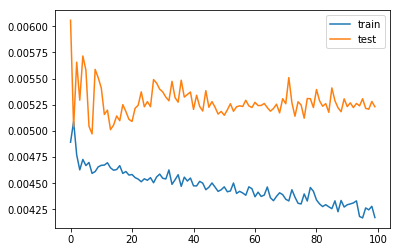

In [66]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [67]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = yhat*2385+135
# invert scaling for actual
test_y = test[:, -12:]
inv_y = test_y.astype('float32')
inv_y = inv_y*2385+135

In [68]:
# calculate RMSE MAPE
rmse={}
mape={}
for i in range(0, 12):
    b = 0
    c = 0
    b = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    c = np.mean(np.abs((inv_y[:,i] - inv_yhat[:,i]) / inv_y[:,i])) * 100
    rmse[i] = b
    mape[i] = c
print(rmse)
print(mape)

{0: 41.64826530516832, 1: 46.97120076357294, 2: 49.80215741122567, 3: 50.212055208697144, 4: 50.098864660133515, 5: 50.14036937064784, 6: 50.278907166518394, 7: 50.39481329493393, 8: 50.406855428788155, 9: 50.61713625267509, 10: 50.73795510158667, 11: 50.87786962115749}
{0: 3.7586364895105362, 1: 4.2544655501842499, 2: 4.6523969620466232, 3: 4.8181835561990738, 4: 5.1019981503486633, 5: 5.5953405797481537, 6: 5.6080233305692673, 7: 5.6193795055150986, 8: 5.9524118900299072, 9: 5.6441102176904678, 10: 6.6321983933448792, 11: 6.2757253646850586}
